In [1]:
import io
import time
import torch
import datasets
import PIL.Image
import numpy as np
import torch.nn as nn
from types import SimpleNamespace
from piq import LPIPS, DISTS, SSIMLoss
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer
from torchvision.transforms.v2 import Pad, CenterCrop
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor

In [2]:
device = "cuda"
lpips_loss = LPIPS().to(device)
dists_loss = DISTS().to(device)
ssim_loss = SSIMLoss().to(device)
kodak = datasets.load_dataset("danjacobellis/kodak", split='validation')
lsdir = datasets.load_dataset("danjacobellis/LSDIR_val", split='validation')
inet = datasets.load_dataset("timm/imagenet-1k-wds",split='validation')
model_path = snapshot_download(repo_id='nvidia/Cosmos-Tokenizer-DI8x8')
encoder = ImageTokenizer(checkpoint_enc=f'{model_path}/encoder.jit').to(device)
decoder = ImageTokenizer(checkpoint_dec=f'{model_path}/decoder.jit').to(device)

/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
img = kodak[4]['image'].convert("RGB")
x_orig = pil_to_tensor(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
orig_dim = x_orig.numel() 
with torch.no_grad():
    z, _ = encoder.encode(x_orig)
    x_hat = decoder.decode(z).to(torch.float).clamp(-1,1)
size_bytes = 2*z.numel()
x_orig_01 = x_orig / 2 + 0.5
x_hat_01 = x_hat / 2 + 0.5
pixels = img.width * img.height
bpp = 8 * size_bytes / pixels
mse = torch.nn.functional.mse_loss(x_orig_01[0], x_hat_01[0])
PSNR = -10 * mse.log10().item()
LPIPS_dB = -10 * np.log10(lpips_loss(x_orig_01.to("cuda"), x_hat_01.to("cuda")).item())
DISTS_dB = -10 * np.log10(dists_loss(x_orig_01.to("cuda"), x_hat_01.to("cuda")).item())
SSIM = 1 - ssim_loss(x_orig_01.to("cuda"), x_hat_01.to("cuda")).item()

In [4]:
print(bpp)

0.25


In [5]:
print(PSNR)

21.658494472503662


In [6]:
print(LPIPS_dB)

7.211713416750213


In [7]:
print(DISTS_dB)

13.540854426620022


In [8]:
print(SSIM)

0.7991160750389099


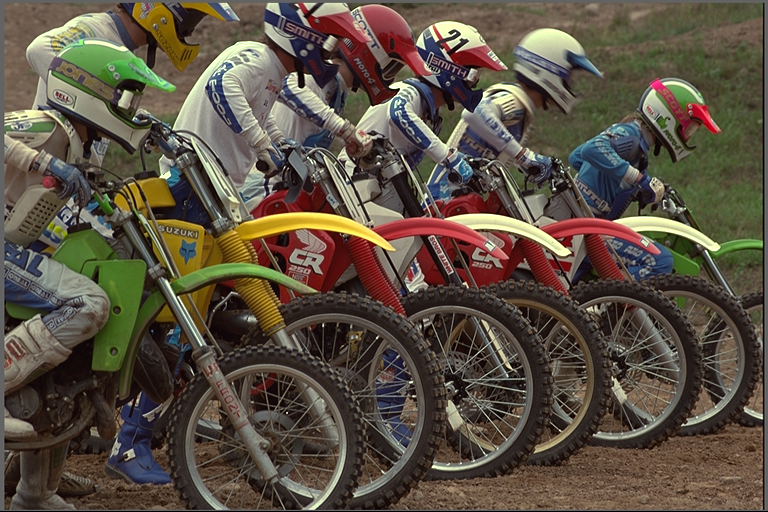

In [9]:
to_pil_image(x_orig[0]/2+0.5)

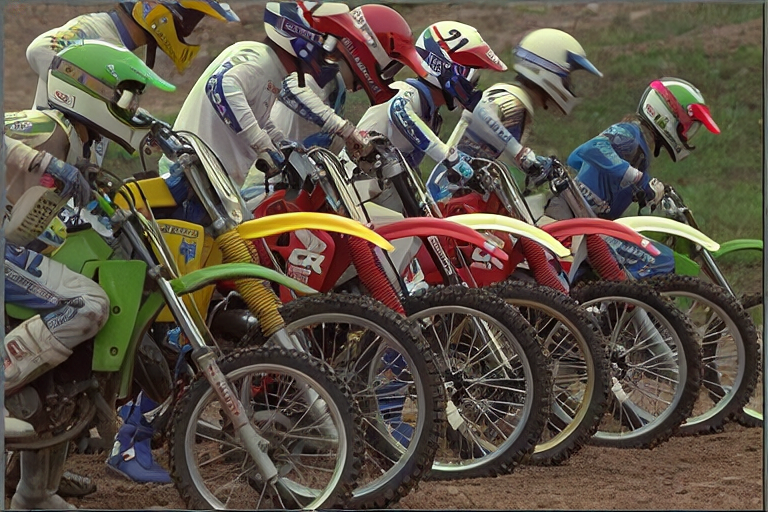

In [10]:
to_pil_image(x_hat[0]/2+0.5)